In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import cvxpy as cp
import itertools as it

def sigmoid(x):
  
    z = np.exp(-x)
    sig = 1 / (1 + z)

    return sig
def generate_signal(alpha, h, chi):
    P = (chi@h + alpha*np.ones(len(h)))
    X = [sigmoid(p) for p in P]
    for i in range(len(X)):
        if .5 < X[i]:
            X[i] = 1
        else:
            X[i] = 0
    return X
def generate_p(alpha, h, chi):
    P = (chi@h + alpha*np.ones(len(h)))
    return P

def Binary_SigRep(Y):
    Yt = np.transpose(Y)
    N = Y.shape[0]
    print("Number of vertices is " + str(N))
    I = np.eye(N)
    indv = [(i,list(it.combinations(I,sum(i)))) for i in Yt if sum(i) > 0]
    print("Indicator vectors built.")
    # Define variables 
    A = cp.Variable((N,N), symmetric = True)
    h = cp.Variable((N,1))
    
    print("CP variables built.")
    # Adjacency Matrix Constraints
    constraints = [cp.diag(A) == 0,
                    A - cp.diag(cp.diag(A)) >= 0]
    
    print("Constraints built.")
    # Define objective 
    obj = cp.Minimize(sum([cp.log(sum([sum([cp.exp(A@k@h) for k in j]) for j in i[1]])) - 
                           cp.transpose(A@h)@i[0] for i in indv]))
    print("Objective built.")
    
    prob = cp.Problem(obj, constraints)
    print("Problem defined")
    print("Problem is DCP:", prob.is_dcp())
    print("Objective is DCP:", obj.is_dcp())
    
    prob.solve(verbose=True)
    print("Problem solved")
    return np.matrix(A.value)

In [16]:
G = nx.fast_gnp_random_graph(10, .2, seed = 123)

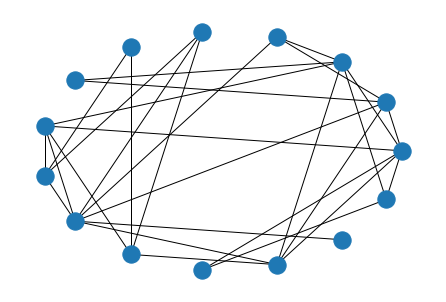

In [3]:
nx.draw_circular(G)

In [17]:
np.random.seed(123)
for s,t in G.edges:
    G[s][t]['weight'] = np.random.uniform(0,1)

In [18]:
for s,t in G.edges:
    print(G.get_edge_data(s,t))

{'weight': 0.6964691855978616}
{'weight': 0.28613933495037946}
{'weight': 0.2268514535642031}
{'weight': 0.5513147690828912}
{'weight': 0.7194689697855631}
{'weight': 0.42310646012446096}
{'weight': 0.9807641983846155}
{'weight': 0.6848297385848633}
{'weight': 0.48093190148436094}
{'weight': 0.3921175181941505}
{'weight': 0.3431780161508694}
{'weight': 0.7290497073840416}
{'weight': 0.4385722446796244}
{'weight': 0.05967789660956835}
{'weight': 0.3980442553304314}
{'weight': 0.7379954057320357}


In [19]:
L = nx.laplacian_matrix(G).toarray()
normL = (L.shape[0]/np.trace(L))*L
A = nx.adjacency_matrix(G)

In [20]:
w, chi = np.linalg.eig(normL)

In [23]:
np.random.seed(123)
h = np.random.normal(0,1, 10)
np.random.seed(123)
alpha = np.random.normal(0,2,50)
print(alpha)

[-2.17126121  1.99469089  0.565957   -3.01258943 -1.1572005   3.30287307
 -4.85335849 -0.85782526  2.53187252 -1.7334808  -1.3577723  -0.18941794
  2.98277925 -1.27780399 -0.88796392 -0.86870255  4.41186017  4.37357218
  2.0081078   0.7723728   1.47473715  2.98146406 -1.87166774  2.35165809
 -2.50776134 -1.275503    1.81421039 -2.8573614  -0.28013744 -1.72350979
 -0.51123874 -5.59717821 -3.54306621 -1.39975447  1.85492486 -0.34727137
  0.00569183  1.37644542 -1.75907269  0.56725465 -1.61073304 -3.45533899
 -0.78179959  1.14761172  0.6771781  -0.02366099  4.78473053  0.82582432
  1.95747201  4.47628668]


In [24]:
# Signal with alpha = 0
y = generate_p(0, h, A)
print(max(y))
print(min(y))

0.9113511918198978
-3.6991946632086528


In [25]:
Y = []
for i in range(len(alpha)):
    signal = generate_signal(alpha[i],h,A)
    Y.append(signal)
    temp = {n:signal[n] for n in G.nodes()}
    nx.set_node_attributes(G, temp, name = "Round " + str(i+1))
Y = np.transpose(Y)
Y.shape

(10, 50)

In [10]:
nx.get_node_attributes(G, name = "Round 1")

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0}

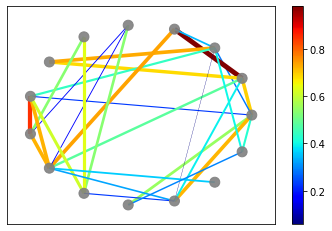

In [70]:

edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
nodes, signal = zip(*nx.get_node_attributes(G,'Round 1').items())
node_color = ['grey']*len(signal)
for i in range(len(signal)):
    if signal[i] == 1:
        node_color[i] = 'black'
size = [w*5 for w in weights]
pos = nx.circular_layout(G)
ec = nx.draw_networkx_edges(G, pos, 
                            edgelist=edges, 
                            edge_color=weights, 
                            width=size,
                            edge_cmap=plt.cm.jet)
nc = nx.draw_networkx_nodes(G,pos,
                            nodelist=nodes,
                            node_color=node_color, 
                            node_size = 100,
                            alpha = .9)
plt.colorbar(ec)

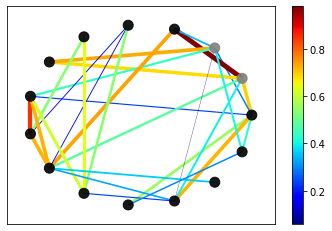

In [71]:

edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
nodes, signal = zip(*nx.get_node_attributes(G,'Round 2').items())
node_color = ['grey']*len(signal)
for i in range(len(signal)):
    if signal[i] == 1:
        node_color[i] = 'black'
size = [w*5 for w in weights]
pos = nx.circular_layout(G)
ec = nx.draw_networkx_edges(G, pos, 
                            edgelist=edges, 
                            edge_color=weights, 
                            width=size,
                            edge_cmap=plt.cm.jet)
nc = nx.draw_networkx_nodes(G,pos,
                            nodelist=nodes,
                            node_color=node_color, 
                            node_size = 100,
                            alpha = .9)
plt.colorbar(ec)

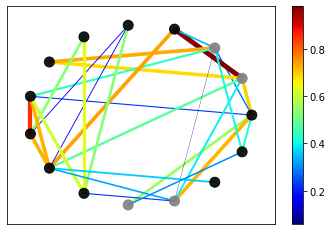

In [72]:

edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
nodes, signal = zip(*nx.get_node_attributes(G,'Round 3').items())
node_color = ['grey']*len(signal)
for i in range(len(signal)):
    if signal[i] == 1:
        node_color[i] = 'black'
size = [w*5 for w in weights]
pos = nx.circular_layout(G)
ec = nx.draw_networkx_edges(G, pos, 
                            edgelist=edges, 
                            edge_color=weights, 
                            width=size,
                            edge_cmap=plt.cm.jet)
nc = nx.draw_networkx_nodes(G,pos,
                            nodelist=nodes,
                            node_color=node_color, 
                            node_size = 100,
                            alpha = .9)
plt.colorbar(ec)

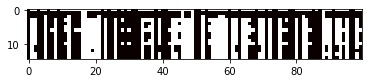

In [11]:
plt.imshow(Y, cmap='hot', interpolation='nearest')
plt.show()

In [10]:
P = chi@h + alpha[1]*np.ones(len(h))
for p in P:
    print(sigmoid(p))

0.7169814376158171
0.8929003203423586
0.5180334847754917
0.6554020329154465
0.589089723614282
0.6796987070980177
0.13783272555754025
0.7977596429883546
0.5091965545036922
0.5215363792283247
0.9543517830756577
0.5201556667314157
0.5139591820133852
0.5415504525111478
0.6640095166373002


In [17]:
diffs = [np.transpose(i)@normL@i for i in np.transpose(Y)]
print(np.mean(diffs), np.std(diffs))

2.322055610074424 1.3927277198211592


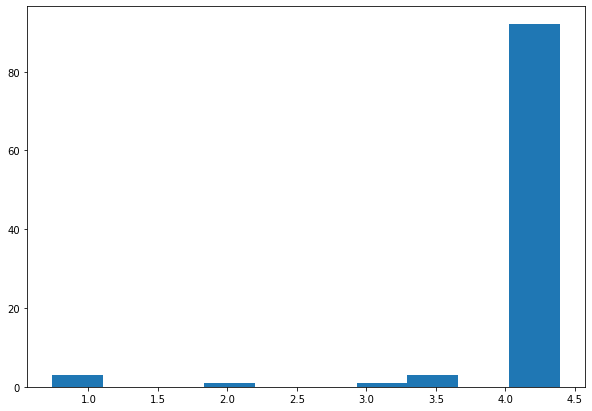

In [12]:
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(diffs)
 
# Show plot
plt.show()

In [13]:
np.random.seed(123)
sd = np.linalg.pinv(np.diag(w))
mu = np.zeros(15)
h2 = np.random.multivariate_normal(mu,sd)
alpha = np.random.uniform(0,1,100)
Y = []
for a in alpha:
    Y.append(generate_signal(a,h2,chi))
Y = np.transpose(np.array(Y))

In [14]:
diffs = [np.transpose(i)@normL@i for i in np.transpose(Y)]
print(np.mean(diffs), np.std(diffs))

2.545684808890243 0.5684291702975246


In [26]:
Yt = np.transpose(Y)
N = Y.shape[0]
print("Number of vertices is " + str(N))
I = np.eye(N)
I = [i.reshape((N,1)) for i in I]
indv = [(i,list(it.combinations(I,sum(i)))) for i in Yt if sum(i) > 0]
print("Indicator vectors built.")
# Define variables 
A = cp.Variable((N,N), symmetric = True)
h = cp.Variable((N,1))

print("CP variables built.")
# Adjacency Matrix Constraints


Number of vertices is 10
Indicator vectors built.
CP variables built.


In [27]:
constraints = [cp.diag(A) == 0,
                A - cp.diag(cp.diag(A)) >= 0]

print("Constraints built.")

Constraints built.


In [28]:
e = 0
for y, jk in indv:
    tmp = 0
    for j in jk:
        for k in j:
            tmp = tmp + cp.exp(cp.transpose(A@k)@h)
    yvec = y.reshape((N,1))
    e = e + cp.log(tmp) + cp.transpose(A@h)@yvec

In [30]:
print(e.is_dcp())

False


In [32]:
beta = cp.Variable(N)
lambd = cp.Parameter(nonneg=True)
X = cp.Variable((N,N), symmetric = True)
log_likelihood = cp.sum(
    cp.multiply(Yt, X @ beta) - cp.logistic(X @ beta)
)

ValueError: Cannot broadcast dimensions  (50, 10) (10,)